In [11]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-yngsky5m
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-yngsky5m
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=5da63700ce1a64b0db1b10a2b66466db409dd5ae95a6db4d89ad1228b3c7c9c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-l3t9q0hv/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [1]:
# importar librerías
import tensorflow as tf

In [12]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

# Importar dataset

In [2]:
import gdown

url = "https://drive.google.com/file/d/1dHpChP3mh0WA-3OdREamvqyRi2pojUIx/view?usp=drive_link"
output = 'sketchy_dataset.7z'
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1dHpChP3mh0WA-3OdREamvqyRi2pojUIx
From (redirected): https://drive.google.com/uc?id=1dHpChP3mh0WA-3OdREamvqyRi2pojUIx&confirm=t&uuid=f02fb38d-5f8a-4eb6-b5f2-7c215365d9fc
To: /content/sketchy_dataset.7z
100%|██████████| 3.62G/3.62G [01:00<00:00, 59.9MB/s]


'sketchy_dataset.7z'

In [3]:
# unzipear
!7z x sketchy_dataset.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 3624446549 bytes (3457 MiB)

Extracting archive: sketchy_dataset.7z
--
Path = sketchy_dataset.7z
Type = 7z
Physical Size = 3624446549
Headers Size = 3523090
Method = LZMA:24
Solid = +
Blocks = 3

  0%      0% - 256x256/photo/tx_000100000000/fish/n01440764_2043.jpg                                                              0% 85 - 256x256/photo/tx_000000000000/shark/n01489920_11936.jpg                                                                   0% 171 - 25

### Funciones

In [47]:
import re as regex

def load_sketchy(image_file):
  #Función para leer y convertir imagen (las 2 que contiene) en tensores
  imagen_sketch = tf.io.read_file(image_file)
  imagen_sketch = tf.io.decode_jpeg(imagen_sketch)

  input_image = tf.cast(imagen_sketch, tf.int32)

  return input_image

In [5]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [6]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [7]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [8]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [9]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

### Dataset

In [65]:
import glob

# Directorios de las carpetas de imágenes
sketch_folder = "/content/256*256/sketch/tx_000000000000/*/*"
photo_folder = "/content/256*256/photo/tx_000000000000/*/*"

# Obtener la lista de rutas de imágenes de cada carpeta usando glob
sketch_images = glob.glob(sketch_folder)
photo_images = glob.glob(photo_folder)

# Crear datasets de TensorFlow con las rutas de las imágenes
sketch_dataset = tf.data.Dataset.from_tensor_slices(sketch_images)
photo_dataset = tf.data.Dataset.from_tensor_slices(photo_images)

# Aplicar la función load_sketchy para cargar y convertir las imágenes en tensores
sketch_dataset = sketch_dataset.map(load_sketchy)
photo_dataset = photo_dataset.map(load_sketchy)

# Convertir datasets a prefetch
sketch_dataset = sketch_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [72]:
len(sketch_dataset)

75481

In [68]:
sample = next(iter(sketch_dataset))

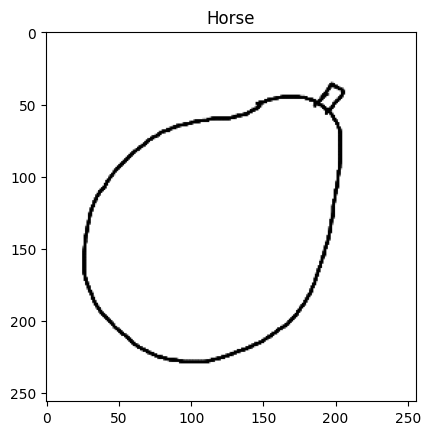

In [69]:
plt.figsize=(10,10)
plt.title('Horse')
plt.imshow(sample)